### Goal ###
Find the nearest [California Data Exchange Center](https://cdec.water.ca.gov/) weather station to each of our California bins. This information will be used to assign each bin weather variable values.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool
%matplotlib inline

Since we have many bins which do not contain a weather monitoring station, the next step is to fill in their values from the nearest station. First find the nearest station to each bin. To do this we will use scipy.spatial.

In [2]:
bins = pd.read_csv('../data/spatial_data/california_bins.csv')
stations = pd.read_csv('../data/CDEC_weather_station_data/target_stations.csv')
stations.columns = ['station','elevation', 'lat', 'long']
stations = stations[stations.long != 0]
bin_array = np.column_stack([bins['long'], bins['lat']])
station_array = np.column_stack([stations['long'], stations['lat']])

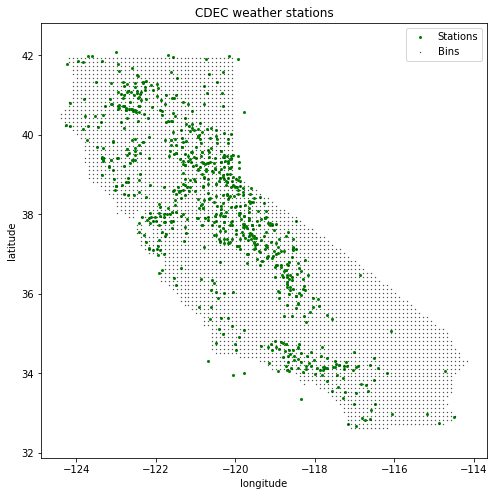

In [57]:
plt.rcParams["figure.figsize"] = (8,8)
plt.scatter(x = stations['long'], y = stations['lat'], color = 'green', s = 4)
plt.scatter(x = bins['long'], y = bins['lat'], color = 'black', s = 0.1)
plt.axis('equal')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('CDEC weather stations')
plt.legend(['Stations', 'Bins'])
plt.show()

In [3]:
from scipy import spatial

station_tree = spatial.cKDTree(station_array)
dist, indexes = station_tree.query(bin_array)

nearest_station_names = []
for index in indexes:
    nearest_station_names.append(stations.iloc[index, 0])
    
bins['nearest_station_name'] = nearest_station_names


Starting with the temperature dataset as a test case, now we will make an hourly time series spanning one day in 2015 and assign each bin a temprature from it's nearest station each hour. 

In [5]:
# Annoying, but here goes...
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

temp_data = pd.read_csv("../data/weather_data/TEMP_1day.csv", parse_dates = ['OBS_DATE'], usecols = ["STATION_ID", "OBS_DATE", "VALUE"], index_col = "OBS_DATE")
temp_data = temp_data[temp_data.VALUE != '---']
temp_data.head()

,STATION_ID,VALUE
OBS_DATE,,
2015-01-01 23:00:00,BCH,9
2015-01-02 00:00:00,BCH,8
2015-01-02 01:00:00,BCH,8
2015-01-02 02:00:00,BCH,7
2015-01-02 03:00:00,BCH,7


In [6]:
temp_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16291 entries, 2015-01-01 23:00:00 to 2015-01-02 23:00:00
Data columns (total 2 columns):
STATION_ID    16291 non-null object
VALUE         16291 non-null int64
dtypes: int64(1), object(1)
memory usage: 381.8+ KB


Here is an example of a station which does not report regularly on the hour. I am sure there are many other cases of this in the dataset. There are also almost certainly missing values. To fix this, we will resample and interpolate to a regular hourly frequency over the whole dataset.

In [7]:
bud_station = temp_data[temp_data['STATION_ID'] == 'BUD']
bud_station.head()

,STATION_ID,VALUE
OBS_DATE,,
2015-01-01 23:00:00,BUD,33
2015-01-01 23:15:00,BUD,33
2015-01-01 23:30:00,BUD,33
2015-01-01 23:45:00,BUD,33
2015-01-02 00:00:00,BUD,33


In [8]:
bud_station_min = bud_station.resample('min')
bud_station_min = bud_station_min.interpolate(method = 'linear')
bud_station_hr = bud_station_min.resample('H')
bud_station_hr = bud_station_hr.interpolate(method = 'linear')
bud_station_hr['STATION_ID'] = 'BUD'
bud_station_hr.head()

,STATION_ID,VALUE
OBS_DATE,,
2015-01-01 23:00:00,BUD,33.0
2015-01-02 00:00:00,BUD,33.0
2015-01-02 01:00:00,BUD,33.0
2015-01-02 02:00:00,BUD,32.0
2015-01-02 03:00:00,BUD,32.0


To run on the whole dataset we will parallelize the above operation:

In [12]:
n_threads = 15

def regularize(group):
    group = group.loc[~group.index.duplicated()] # without this line, get 'ValueError: 
                                                  # cannot reindex from a duplicate axis'
    group = group.resample('min')
    group = group.interpolate(method = 'linear')
    group = group.resample('H')
    group = group.interpolate(method = 'linear')
    return group

def group_data(temp_data_split):
    grouped_data = temp_data_split.groupby('STATION_ID')
    return grouped_data.apply(regularize)
    
def parallelize(temp_data, func, n_cores = n_threads):
    '''Parallelizes regularization, takes temp data and
    splits up regularization fuction over avalibile threads'''
    temp_data_split = np.array_split(temp_data, n_cores)
    pool = Pool(n_cores)
    result = pd.concat(pool.map(func, temp_data_split))
    pool.close()
    pool.join()
    return result
    
regularized_temp_data = parallelize(temp_data, group_data)

regularized_temp_data['STATION_ID'] = regularized_temp_data.index.get_level_values(0)
regularized_temp_data = regularized_temp_data.reset_index(level = 0, drop = True)
regularized_temp_data = regularized_temp_data.set_index(['STATION_ID'], append = True)

# Not sure I actualy need any of this stuff but it was in the last working version
#regularized_temp_data['VALUE'].replace('', np.nan, inplace = True) 
#regularized_temp_data.dropna(subset = ['VALUE'], inplace = True)
#regularized_temp_data = regularized_temp_data.loc[~regularized_temp_data.index.duplicated()]

regularized_temp_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 12112 entries, (2015-01-01 23:00:00, ALD) to (2015-01-02 23:00:00, ZEN)
Data columns (total 1 columns):
VALUE    12109 non-null float64
dtypes: float64(1)
memory usage: 134.2+ KB


In [13]:
regularized_temp_data.head()

,,VALUE
OBS_DATE,STATION_ID,
2015-01-01 23:00:00,ALD,35.0
2015-01-02 00:00:00,ALD,33.0
2015-01-02 01:00:00,ALD,33.0
2015-01-02 02:00:00,ALD,32.0
2015-01-02 03:00:00,ALD,31.0


In [23]:
date_range_start = regularized_temp_data.index.get_level_values(0).min()
date_range_end = regularized_temp_data.index.get_level_values(0).max()

In [39]:
time_series = pd.date_range(date_range_start, date_range_end, freq = "H").to_series()
time_series

2015-01-01 23:00:00   2015-01-01 23:00:00
2015-01-02 00:00:00   2015-01-02 00:00:00
2015-01-02 01:00:00   2015-01-02 01:00:00
2015-01-02 02:00:00   2015-01-02 02:00:00
2015-01-02 03:00:00   2015-01-02 03:00:00
2015-01-02 04:00:00   2015-01-02 04:00:00
2015-01-02 05:00:00   2015-01-02 05:00:00
2015-01-02 06:00:00   2015-01-02 06:00:00
2015-01-02 07:00:00   2015-01-02 07:00:00
2015-01-02 08:00:00   2015-01-02 08:00:00
2015-01-02 09:00:00   2015-01-02 09:00:00
2015-01-02 10:00:00   2015-01-02 10:00:00
2015-01-02 11:00:00   2015-01-02 11:00:00
2015-01-02 12:00:00   2015-01-02 12:00:00
2015-01-02 13:00:00   2015-01-02 13:00:00
2015-01-02 14:00:00   2015-01-02 14:00:00
2015-01-02 15:00:00   2015-01-02 15:00:00
2015-01-02 16:00:00   2015-01-02 16:00:00
2015-01-02 17:00:00   2015-01-02 17:00:00
2015-01-02 18:00:00   2015-01-02 18:00:00
2015-01-02 19:00:00   2015-01-02 19:00:00
2015-01-02 20:00:00   2015-01-02 20:00:00
2015-01-02 21:00:00   2015-01-02 21:00:00
2015-01-02 22:00:00   2015-01-02 2

Now we make a dataframe of 'noxels' or n-dimentional voxels. Each row will be a bin at a specific time. Once we have this dataframe, we can go back though and assign weather variable values to each noxel.

In [59]:
def apply_to_bins(time_series, bins):
    return bins.assign(time = time_series)

empty_noxels = pd.concat(time_series.apply(apply_to_bins, args = (bins,)).tolist())
empty_noxels.to_csv('../data/spatial_data/empty_noxels.csv', index = False)
empty_noxels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103400 entries, 0 to 4135
Data columns (total 4 columns):
long                    103400 non-null float64
lat                     103400 non-null float64
nearest_station_name    103400 non-null object
time                    103400 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 3.9+ MB


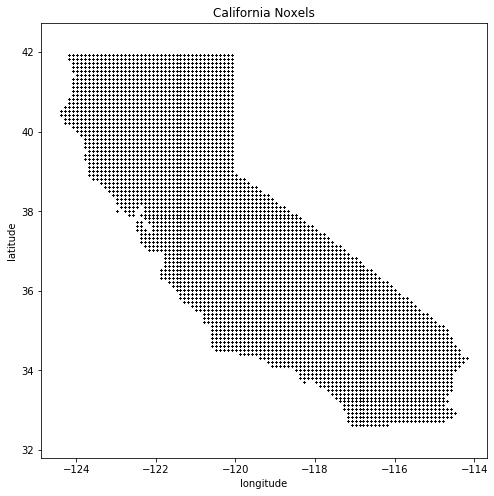

In [61]:
plt.rcParams["figure.figsize"] = (8,8)
plt.scatter(x = empty_noxels['long'], y = empty_noxels['lat'], color = 'black', s = 0.1)
plt.axis('equal')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('California Noxels')
plt.show()

In [62]:
regularized_temp_data.at[('2015-01-01 23:00:00', 'ACN'), 'VALUE']

31.0

In [63]:
n_threads = 14

def try_except(row):
    try:
        return mt_regularized_temp_data.loc[(row['time'], row['nearest_station_name']), 'VALUE']
    except:
        return np.nan
    
def add_data(noxels):
    noxels['temp'] = noxels.apply(lambda row: try_except(row), axis = 1)
    return noxels

def parallelize(noxels, func, n_cores = n_threads):
    '''Parallelizes downsampling, takes list of stations and
    splits up the downsampling fuction over avalibile threads'''
    noxels_split = np.array_split(noxels, n_cores)
    pool = Pool(n_cores)
    result = pd.concat(pool.map(func, noxels_split))
    pool.close()
    pool.join()
    return result

noxels = parallelize(empty_noxels, add_data)

#noxels = noxels.dropna()
noxels.to_csv('../data/training_data/noxels_1day.csv', index = False)
noxels.head()

,long,lat,nearest_station_name,time,temp
0,-117.08,32.62,SMG,2015-01-01 23:00:00,44.0
1,-116.98,32.62,SMG,2015-01-01 23:00:00,44.0
2,-116.88,32.62,SMG,2015-01-01 23:00:00,44.0
3,-116.78,32.62,SMG,2015-01-01 23:00:00,44.0
4,-116.68,32.62,API,2015-01-01 23:00:00,34.0


In [64]:
noxels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103400 entries, 0 to 4135
Data columns (total 5 columns):
long                    103400 non-null float64
lat                     103400 non-null float64
nearest_station_name    103400 non-null object
time                    103400 non-null datetime64[ns]
temp                    71227 non-null float64
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 4.7+ MB


OK, so, working to a first approximation. Lets check some lengths and see how we did. If we filled every bin with a temperature value, then we should have bins x time_series rows in our data file...

In [65]:
(len(noxels) / (len(bins) * len(time_series))) * 100

100.0

In [66]:
noxels_one_hour = noxels[noxels['time'] == '2015-01-01 23:00:00']

In [67]:
noxels_one_hour.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4136 entries, 0 to 4135
Data columns (total 5 columns):
long                    4136 non-null float64
lat                     4136 non-null float64
nearest_station_name    4136 non-null object
time                    4136 non-null datetime64[ns]
temp                    2846 non-null float64
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 193.9+ KB


In [ ]:
plt.rcParams["figure.figsize"] = (8,8)
plt.scatter(x = noxels_one_hour['long'], y = noxels_one_hour['lat'], color = 'black', s = 1)
plt.axis('equal')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('California Noxels')
plt.show()